In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

from mpl_toolkits.basemap import Basemap
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import SCORERS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeCV, LassoCV
from scipy import sparse
from sklearn.metrics import mean_squared_error, mean_absolute_error
import random
PATH = './data/'

In [2]:
from jupyterthemes import jtplot
jtplot.style(theme='onedork')

In [3]:
file_name_cr = 'crime.csv'
df_crime = pd.read_csv(PATH+file_name_cr, encoding = "ISO-8859-1")


## 1. Описание набора данных и признаков  (2 балла)
Описан процесс сбора данных (если применимо), 
есть подробное описание решаемой задачи, 
в чем ее ценность, 
дано описание целевого и прочих признаков;

In [4]:
df_crime.head()

INCIDENT_NUMBER  OFFENSE_CODE  OFFENSE_CODE_GROUP  \
0      I182080058          2403  Disorderly Conduct   
1      I182080053          3201       Property Lost   
2      I182080052          2647               Other   
3      I182080051           413  Aggravated Assault   
4      I182080050          3122            Aircraft   

              OFFENSE_DESCRIPTION DISTRICT REPORTING_AREA SHOOTING  \
0            DISTURBING THE PEACE      E18            495      NaN   
1                 PROPERTY - LOST      D14            795      NaN   
2       THREATS TO DO BODILY HARM       B2            329      NaN   
3  ASSAULT - AGGRAVATED - BATTERY       A1             92      NaN   
4              AIRCRAFT INCIDENTS       A7             36      NaN   

      OCCURRED_ON_DATE  YEAR  MONTH DAY_OF_WEEK  HOUR    UCR_PART  \
0  2018-10-03 20:13:00  2018     10   Wednesday    20    Part Two   
1  2018-08-30 20:00:00  2018      8    Thursday    20  Part Three   
2  2018-10-03 19:20:00  2018     10   Wednesday    19    Part Two   
3  2018-10-03 20:00:00  2018     10   Wednesday    20    Part One   
4  2018-10-03 20:49:00  2018     10   Wednesday    20  Part Three   

         STREET        Lat       Long                     Location  
0  ARLINGTON ST  42.262608 -71.121186  (42.26260773, -71.12118637)  
1    ALLSTON ST  42.352111 -71.135311  (42.35211146, -71.13531147)  
2      DEVON ST  42.308126 -71.076930  (42.30812619, -71.07692974)  
3  CAMBRIDGE ST  42.359454 -71.059648  (42.35945371, -71.05964817)  
4   PRESCOTT ST  42.375258 -71.024663  (42.37525782, -71.02466343)

In [5]:
file_name_weather = 'Boston weather_clean.csv'
df_weather = pd.read_csv(PATH+file_name_weather, encoding = "ISO-8859-1")

In [6]:
df_weather.tail()


Year  Month  Day  High Temp (F)  Avg Temp (F)  Low Temp (F)  \
3744  2018      4    4             58            49            39   
3745  2018      4    5             43            37            30   
3746  2018      4    6             43            36            29   
3747  2018      4    7             47            41            35   
3748  2018      4    8             42            37            32   

      High Dew Point (F)  Avg Dew Point (F)  Low Dew Point (F)  \
3744                  56                 42                 19   
3745                  21                  9                  4   
3746                  38                 27                  9   
3747                  38                 26                 16   
3748                  21                 17                 11   

      High Humidity (%)   ...    Low Sea Level Press (in)  \
3744                100   ...                       29.29   
3745                 48   ...                       29.65   
3746                100   ...                       29.71   
3747                 92   ...                       29.69   
3748                 52   ...                       29.76   

      High Visibility (mi)  Avg Visibility (mi)  Low Visibility (mi)  \
3744                    10                    4                    0   
3745                    10                   10                   10   
3746                    10                    8                    0   
3747                    10                   10                   10   
3748                    10                   10                   10   

      High Wind (mph)  Avg Wind (mph)  High Wind Gust (mph)  Snowfall (in)  \
3744               31              13                    42           0.00   
3745               35              22                    44           0.00   
3746               22              11                    26           0.21   
3747               20              12                    27           0.00   
3748               22              13                    29           0.00   

      Precip (in)  Events  
3744         0.20    Rain  
3745         0.00    None  
3746         0.21    Both  
3747         0.01    Rain  
3748         0.00    None  

[5 rows x 24 columns]

### 2.  Первичный анализ данных  (4 балла)
Исследованы признаки, их взаимодействия, влияние на целевой признак. 
Исследовано распределение целевого признака (в случае задачи регрессии проведены стат-тесты на нормальность и скошенность (skewness) распределения). 
Если необходимо, объясняется, почему и как можно преобразовать целевой признак. 
Изучены выбросы и пропуски в данных;

Пропуски

In [7]:
df_crime.isnull().sum()

INCIDENT_NUMBER             0
OFFENSE_CODE                0
OFFENSE_CODE_GROUP          0
OFFENSE_DESCRIPTION         0
DISTRICT                 1774
REPORTING_AREA              0
SHOOTING               326765
OCCURRED_ON_DATE            0
YEAR                        0
MONTH                       0
DAY_OF_WEEK                 0
HOUR                        0
UCR_PART                   93
STREET                  10977
Lat                     20632
Long                    20632
Location                    0
dtype: int64

посмотрим какие районы

In [8]:
df_crime.DISTRICT.value_counts()

B2     51288
C11    43817
D4     43338
A1     36735
B3     36400
C6     24190
D14    20632
E13    17981
E18    17825
A7     13634
E5     13543
A15     6663
Name: DISTRICT, dtype: int64

In [9]:
df_crime.DISTRICT = df_crime.DISTRICT.fillna('NON')

In [10]:
df_crime.SHOOTING = df_crime.SHOOTING.fillna('NON')

In [11]:
df_crime.UCR_PART.value_counts()

Part Three    162928
Part Two      100283
Part One       63231
Other           1285
Name: UCR_PART, dtype: int64

In [12]:
df_crime.UCR_PART = df_crime.UCR_PART.fillna('Other')

In [13]:
len(df_crime.STREET.unique())

4685

In [14]:
df_crime.STREET = df_crime.STREET.fillna('Other')

In [15]:
df_crime[np.isnan(df_crime.Lat)]['Location'].unique()

array(['(0.00000000, 0.00000000)'], dtype=object)

In [16]:
df_crime = df_crime[~np.isnan(df_crime.Lat)]

In [17]:
df_crime.isnull().sum()

INCIDENT_NUMBER        0
OFFENSE_CODE           0
OFFENSE_CODE_GROUP     0
OFFENSE_DESCRIPTION    0
DISTRICT               0
REPORTING_AREA         0
SHOOTING               0
OCCURRED_ON_DATE       0
YEAR                   0
MONTH                  0
DAY_OF_WEEK            0
HOUR                   0
UCR_PART               0
STREET                 0
Lat                    0
Long                   0
Location               0
dtype: int64

In [18]:
df_weather.isnull().sum()

Year                         0
Month                        0
Day                          0
High Temp (F)                0
Avg Temp (F)                 0
Low Temp (F)                 0
High Dew Point (F)           0
Avg Dew Point (F)            0
Low Dew Point (F)            0
High Humidity (%)            0
Avg Humidity (%)             0
Low Humidity (%)             0
High Sea Level Press (in)    0
Avg Sea Level Press (in)     0
Low Sea Level Press (in)     0
High Visibility (mi)         0
Avg Visibility (mi)          0
Low Visibility (mi)          0
High Wind (mph)              0
Avg Wind (mph)               0
High Wind Gust (mph)         0
Snowfall (in)                0
Precip (in)                  0
Events                       0
dtype: int64

In [19]:
df_crime.OFFENSE_CODE_GROUP.value_counts()

Motor Vehicle Accident Response              31874
Larceny                                      25900
Medical Assistance                           23158
Investigate Person                           18471
Other                                        17615
Simple Assault                               15356
Vandalism                                    15292
Drug Violation                               15081
Verbal Disputes                              13338
Towed                                        11120
Investigate Property                         10982
Larceny From Motor Vehicle                   10555
Property Lost                                 9690
Warrant Arrests                               7793
Aggravated Assault                            7470
Fraud                                         5922
Residential Burglary                          5701
Violations                                    5192
Missing Person Located                        5047
Auto Theft                     

In [20]:
df_crime.OFFENSE_CODE.value_counts()

3006    18481
3115    18475
1402    15033
3831    14956
802     14340
3301    13338
3410    11120
3114    10982
617      9135
2647     9109
3201     8803
614      8632
613      8006
3125     7793
619      5886
3802     5553
413      4654
1102     4502
3502     4448
2629     4078
3803     3983
3501     3769
3207     3542
724      3424
2610     3197
1106     3165
423      2807
301      2789
520      2622
2900     2544
        ...  
770         2
123         2
2910        2
1002        2
2672        2
1866        2
623         2
629         2
1620        2
637         1
530         1
2606        1
639         1
402         1
404         1
432         1
714         1
527         1
624         1
627         1
2609        1
112         1
349         1
1105        1
547         1
335         1
1864        1
1863        1
315         1
511         1
Name: OFFENSE_CODE, Length: 219, dtype: int64

In [21]:
min(df_crime.Lat), max(df_crime.Lat)

(-1.0, 42.39504158)

In [22]:
min(df_crime.Long), max(df_crime.Long)

(-71.17867378, -1.0)

В координатах есть выбросы

## 3. Первичный визуальный анализ данных (4 балла)
(+) Построены визуализации (распределения признаков, матрица корреляций и т.д.), описана связь с анализом данным (п. 2). Присутствуют выводы;

In [23]:
df_crime.OCCURRED_ON_DATE = df_crime.OCCURRED_ON_DATE.map(pd.to_datetime)

In [24]:
df_crime['test_one'] = 1

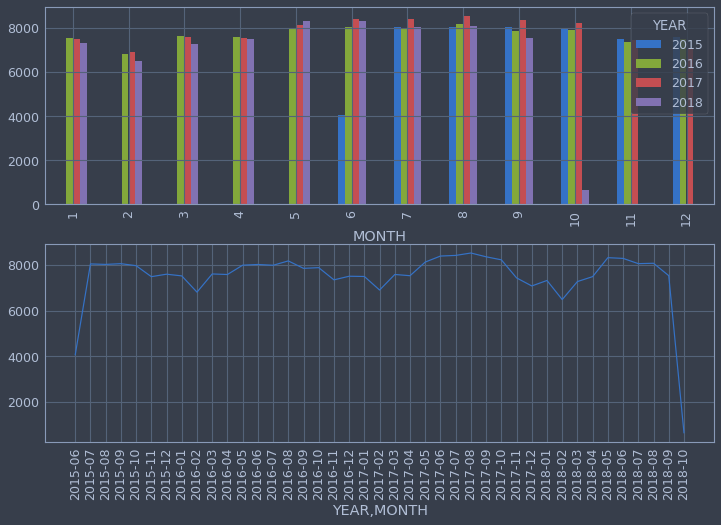

In [25]:
g = df_crime.groupby(('YEAR','MONTH'))['test_one'].sum()
fig = plt.figure(1, (12, 8))
ax1 = fig.add_subplot(211)
g.unstack(level=0).plot(kind='bar', grid = True, ax = ax1);
ax2 = fig.add_subplot(212)

g.plot(grid = True, ax = ax2);
ax2.set_xticks(range(len(g)));
ax2.set_xticklabels(["%s-%02d" % item for item in g.index.tolist()], rotation=90);

больше всего преступлений совершается летом, меньше всего зимой. среднее количество правонарушений остается постоянной

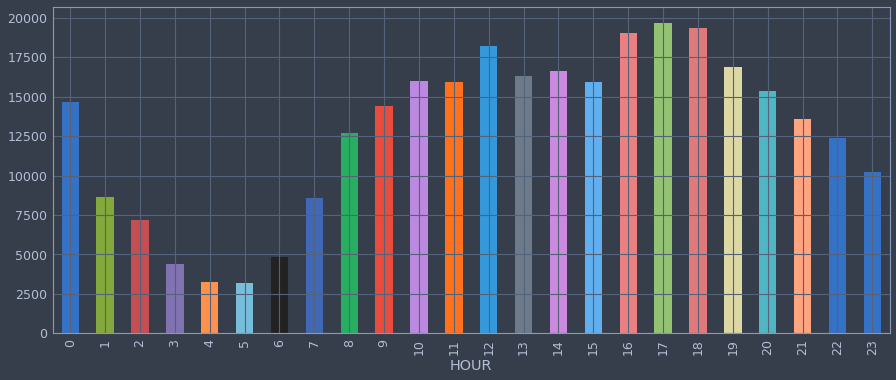

In [26]:
df_crime.groupby(('HOUR'))['test_one'].sum().plot(kind='bar',figsize=(15,6), grid = True);

больше всего преступлений совершается после обеда, меньше всего поздно ночью

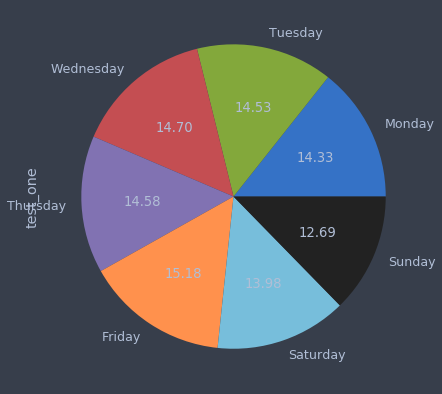

In [27]:
order = ['Monday', 'Tuesday', 'Wednesday','Thursday','Friday','Saturday','Sunday']
df_crime.groupby(('DAY_OF_WEEK'))['test_one'].sum().loc[order].plot(kind = 'pie', figsize=(7, 7), autopct='%.2f');

к выходным число преступлений снижается

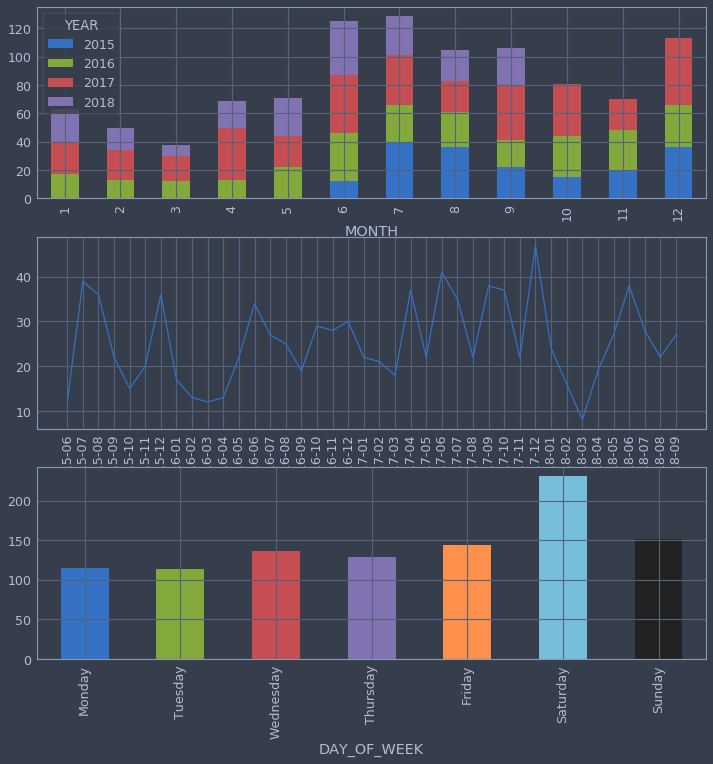

In [28]:
g = df_crime[df_crime.SHOOTING != 'NON'].groupby(('YEAR','MONTH'))['test_one'].sum()
fig = plt.figure(1, (12, 12))
ax1 = fig.add_subplot(311)
g.unstack(level=0).plot(kind='bar', grid = True, ax = ax1, stacked=True);
ax2 = fig.add_subplot(312)
g.plot(grid = True, ax = ax2);
ax2.set_xticks(range(len(g)));
ax2.set_xticklabels(["%s-%02d" % item for item in g.index.tolist()], rotation=90);

g = df_crime[df_crime.SHOOTING != 'NON'].groupby(('DAY_OF_WEEK'))['test_one'].sum().loc[order]
ax3 = fig.add_subplot(313)
g.plot(kind='bar', grid = True, ax = ax3, stacked=True);

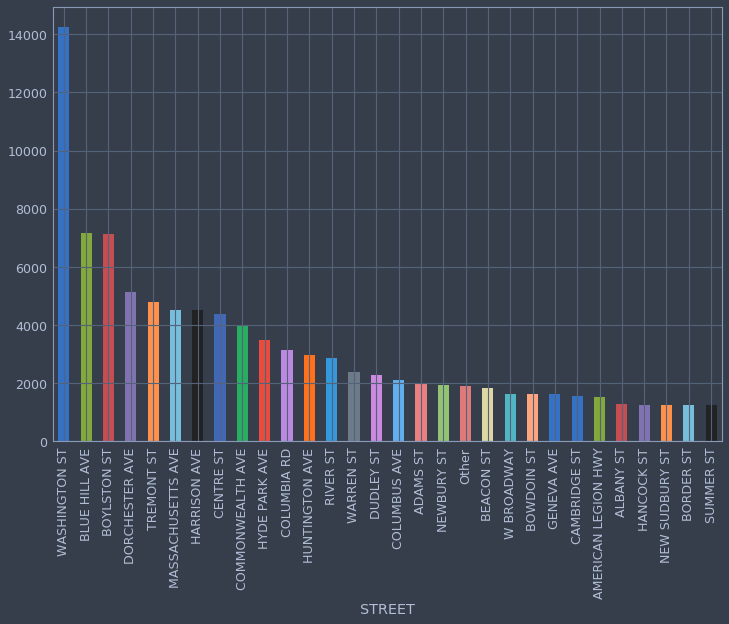

In [29]:
g = df_crime.groupby(('STREET'))['test_one'].sum().sort_values(ascending = False).head(30)
fig = plt.figure(1, (12, 8))
#ax1 = fig.add_subplot(211)
g.plot(kind='bar', grid = True);

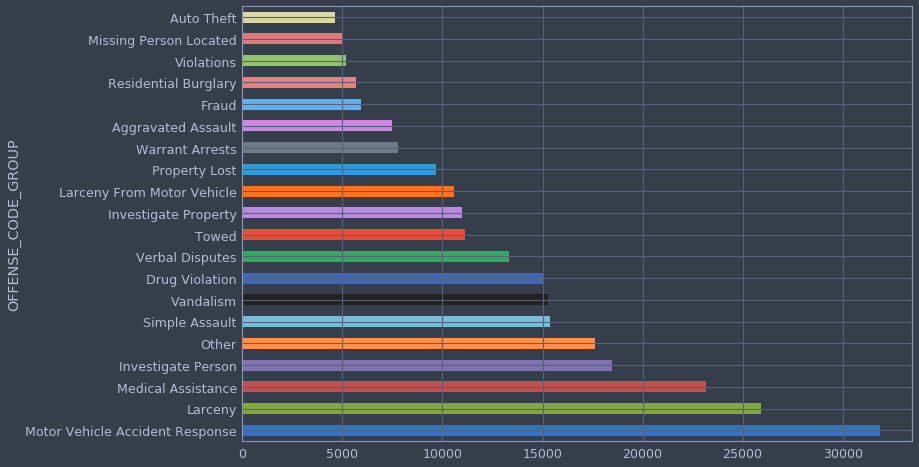

In [30]:
g = df_crime.groupby(('OFFENSE_CODE_GROUP'))['test_one'].sum().sort_values(ascending = False).head(20)
fig = plt.figure(1, (12, 8))
#ax1 = fig.add_subplot(211)
g.plot(kind='barh', grid = True);

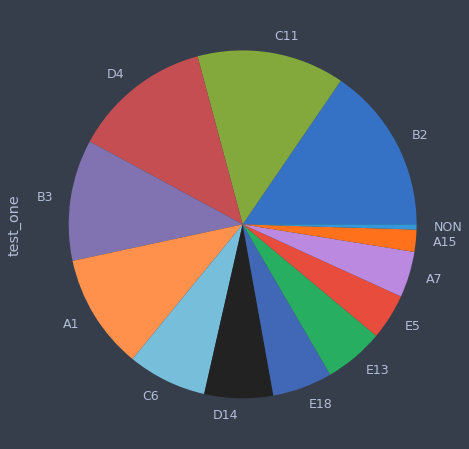

In [31]:
g = df_crime.groupby(('DISTRICT'))['test_one'].sum().sort_values(ascending = False).head(20)
fig = plt.figure(1, (12, 8))
#ax1 = fig.add_subplot(211)
g.plot(kind='pie', grid = True);

In [32]:
df_crime_pre =  df_crime[(df_crime.Lat > 20) & (df_crime['Long']<-20)]

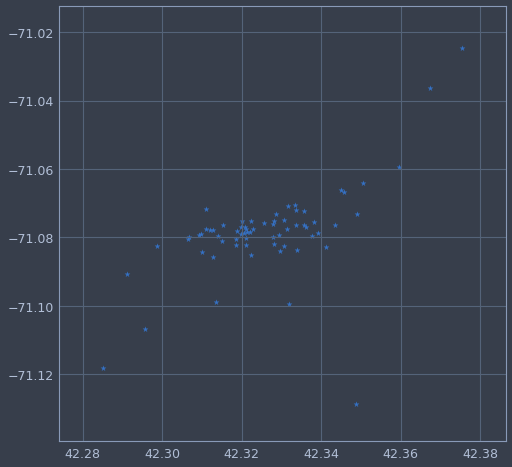

In [33]:
g = df_crime_pre.groupby(('OFFENSE_CODE_GROUP'))['Lat', 'Long', 'test_one'].aggregate((np.sum,  np.median)).sort_values(by = ('test_one','sum'), ascending = False)

fig = plt.figure(1, (8, 8))
#ax1 = fig.add_subplot(211)
plt.scatter(x = g[('Lat','median')].values, y = g[('Long','median')].values, marker = '*');

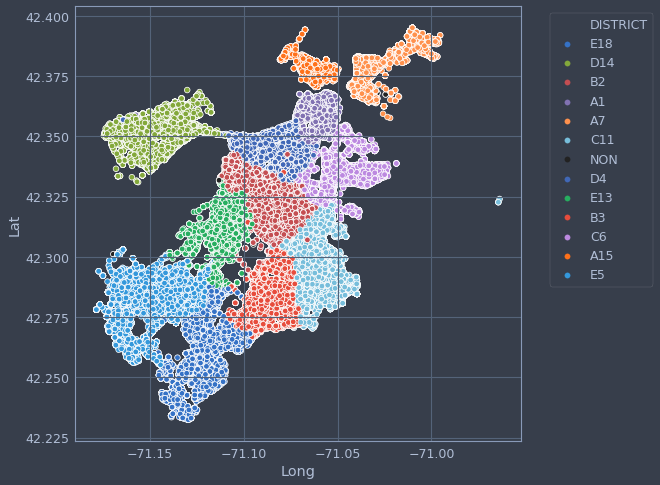

In [34]:
fig = plt.figure(1, (8, 8))
sns.scatterplot(x='Long',  y='Lat',   hue='DISTRICT',   data=df_crime_pre)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2);

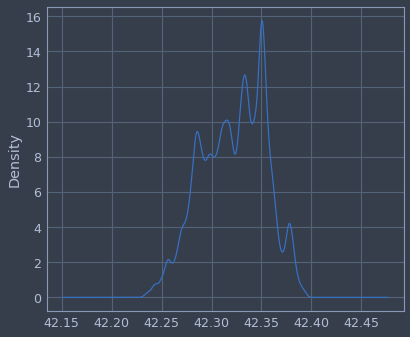

In [35]:
df_crime_pre['Lat'].plot(kind='kde');

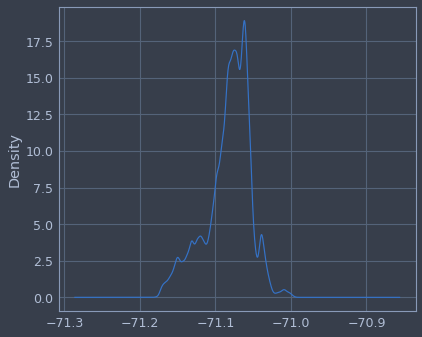

In [36]:
df_crime_pre['Long'].plot(kind='kde');

In [37]:
df_crime_pre['DAY'] = df_crime_pre['OCCURRED_ON_DATE'].dt.day

In [38]:
df_total = df_crime_pre.merge(df_weather, left_on=['YEAR', 'MONTH', 'DAY'], right_on=['Year', 'Month', 'Day'])

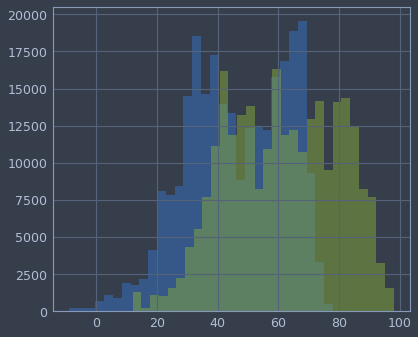

In [39]:
# количество преступлений и температуры
plt.figure();
df_total['Low Temp (F)'].hist(alpha = 0.5, bins = 30);
df_total['High Temp (F)'].hist(alpha = 0.5, bins = 30);

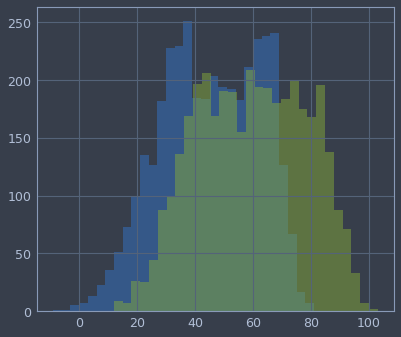

In [40]:
# это реальное распределение температуры
plt.figure();
df_weather['Low Temp (F)'].hist(alpha = 0.5, bins = 30);
df_weather['High Temp (F)'].hist(alpha = 0.5, bins = 30);

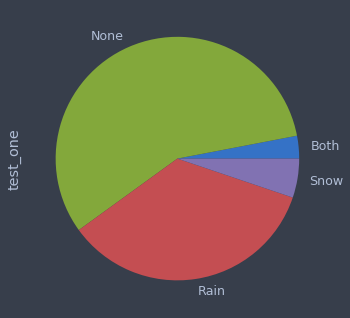

In [41]:
df_total.groupby('Events')['test_one'].aggregate(np.sum).plot.pie();
# какие осадки были в момент преступления

вычислим корреляцию между переменными

In [42]:
def plot_corr(df,size=10):
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    cs = ax.matshow(corr, interpolation='none', cmap='plasma')
    plt.xticks(range(len(corr.columns)), corr.columns,  rotation=90);
    plt.yticks(range(len(corr.columns)), corr.columns);
    cbar = fig.colorbar(cs, ax=ax, shrink=0.7) 

In [43]:
df_dummies_OFFENSE_CODE_GROUP = pd.get_dummies(df_total['OFFENSE_CODE_GROUP'])
df_dummies_Events = pd.get_dummies(df_total['Events'])
df_dummies_DISTRICT = pd.get_dummies(df_total['DISTRICT'])
#df_dummies_SHOOTING = pd.get_dummies(df_total['SHOOTING'])
df_dummies_UCR_PART = pd.get_dummies(df_total['UCR_PART'])
df_dummies_STREET = pd.get_dummies(df_total['STREET'])

df_new = pd.concat([df_dummies_OFFENSE_CODE_GROUP, df_dummies_Events, df_dummies_DISTRICT, df_dummies_UCR_PART,  df_total[['Lat', 'Long']], df_total.iloc[:, 23:42]], axis=1)



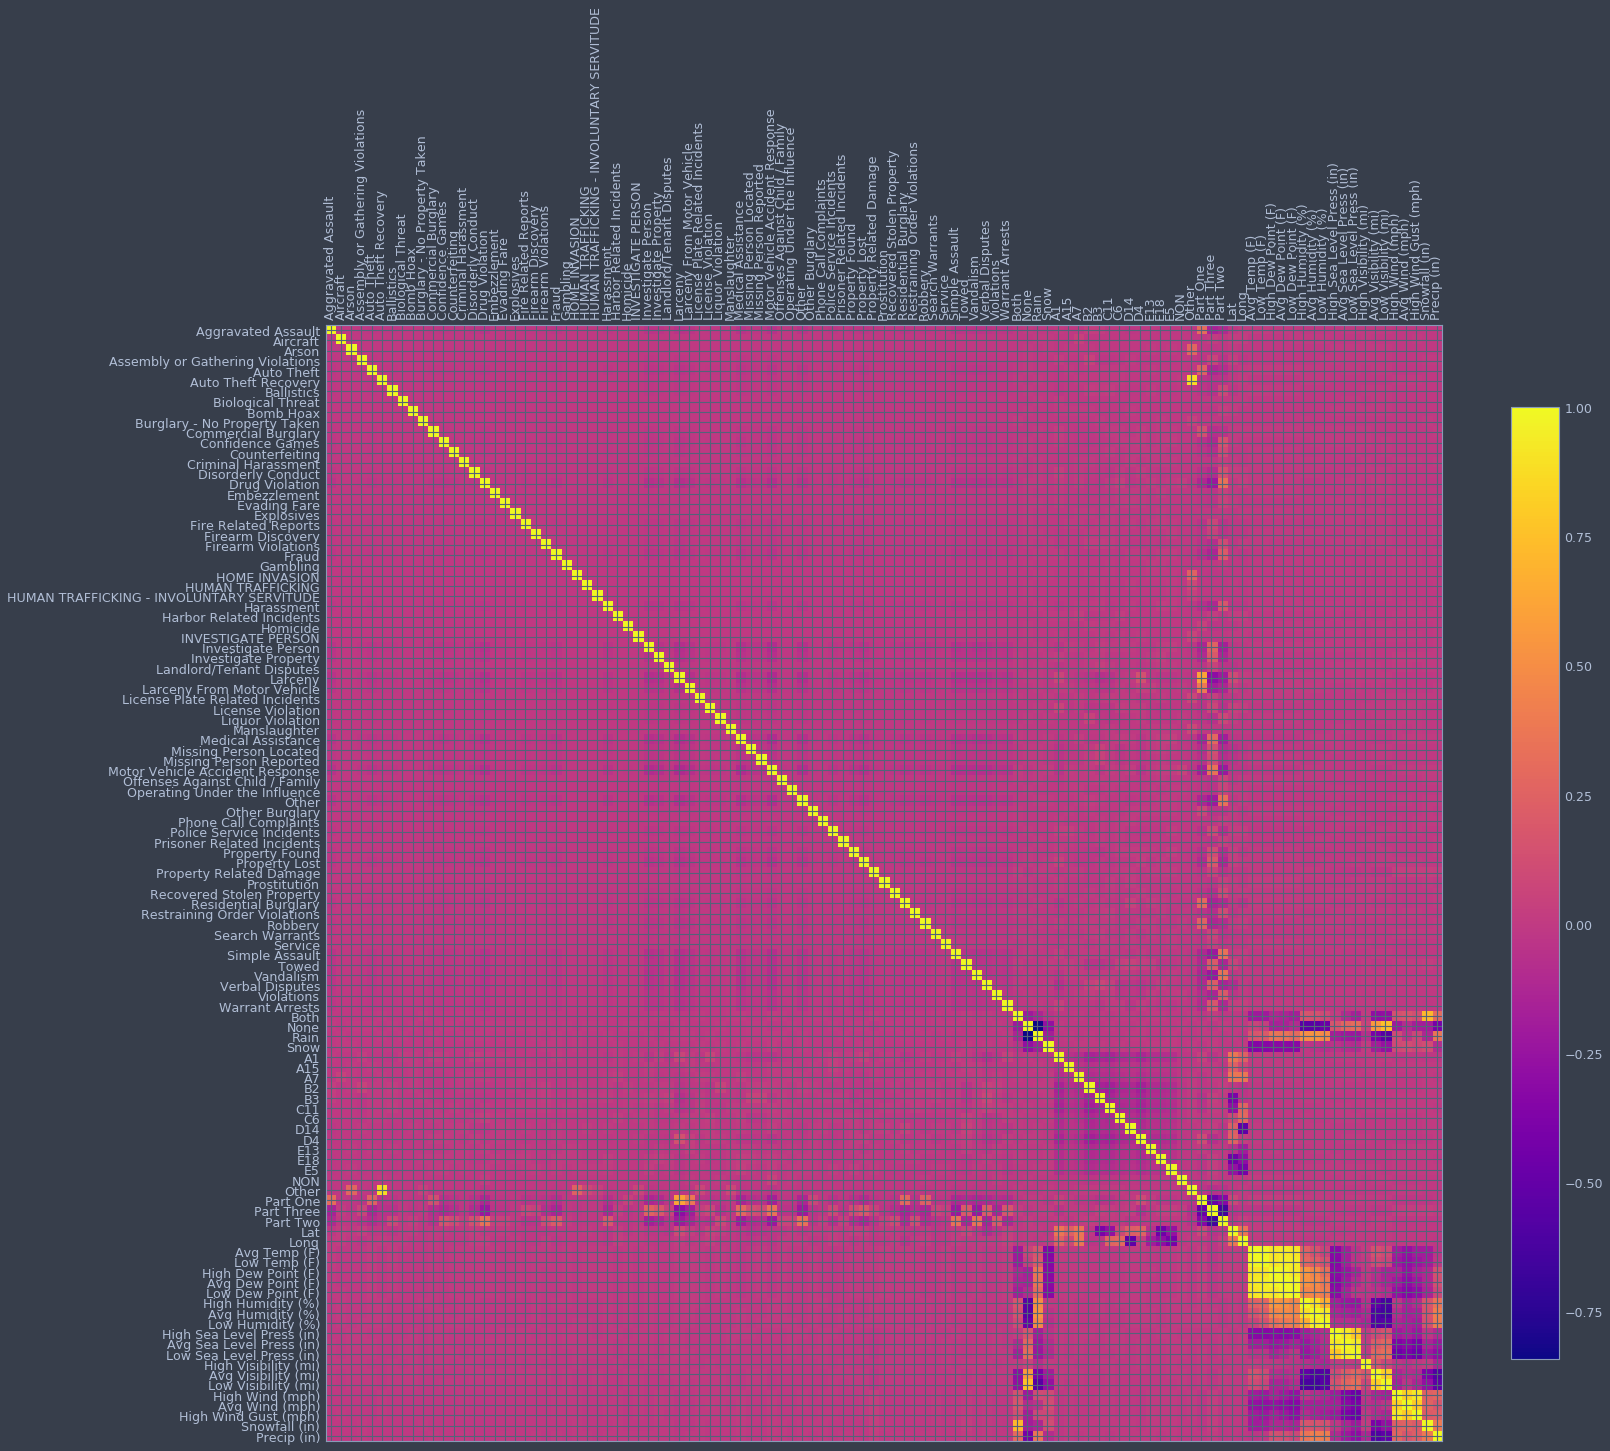

In [44]:
plot_corr(df_new, 25)

http://server.arcgisonline.com/ArcGIS/rest/services/World_Street_Map/MapServer/export?bbox=-71.2,42.2,-70.95,42.46&bboxSR=4269&imageSR=4269&size=1000,1039&dpi=96&format=png32&transparent=true&f=image


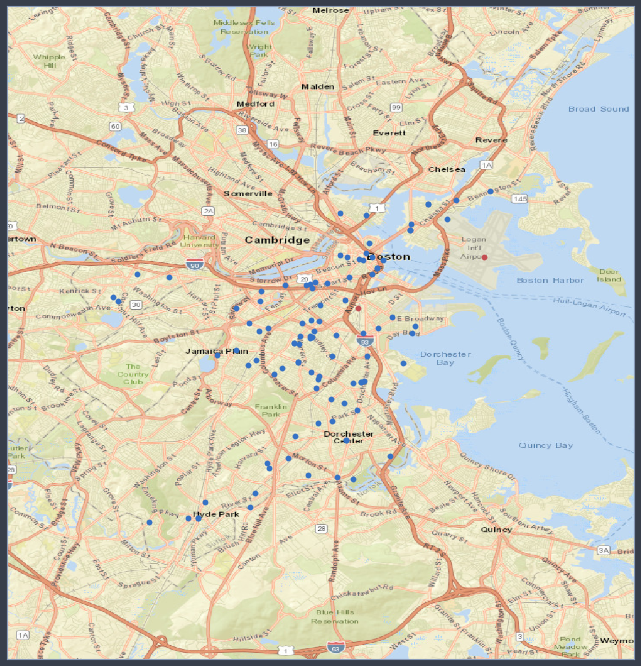

In [45]:
plt.figure(figsize=(12,12))
map = Basemap(llcrnrlon=-71.2, llcrnrlat=42.2, urcrnrlon=-70.95, urcrnrlat=42.46, epsg=4269)
    #http://server.arcgisonline.com/arcgis/rest/services
    #EPSG Number of America is 4269
#World_Street_Map
#World_Topo_Map
map.arcgisimage(service='World_Street_Map', xpixels = 1000, verbose= True)
for i in range(100):
    xpt,ypt = map(df_crime.Long[i], df_crime.Lat[i])
    map.scatter(xpt,ypt,c = 'b')

# коориинаты аэропорта
coo_aero = (-71.01, 42.36)
xpt,ypt = map(coo_aero[0],coo_aero[1])
map.scatter(xpt,ypt,c = 'r')
# южный вокзал
coo_v1 = (-71.06, 42.34)
xpt,ypt = map(coo_v1[0],coo_v1[1])
map.scatter(xpt,ypt,c = 'r')
plt.show()

## 4. Инсайты, найденные зависимости (4 балла)
(+) Найдены и выдвинуты предположения о природе различных корреляций/пропусков/закономерностей и выбросов, найденных в предыдущих пунктах. Есть пояснение, почему они важны для решаемой задачи;

## 5. Выбор метрики (3 балла)
(+) Есть разумное обоснование выбора метрики качества модели. Описаны моменты, влияющие на выбор метрики качества (решаемая задача, цель решения, количество классов, дисбаланс классов, прочее);

## 6. Выбор модели (3 балла)
(+) Произведен выбор модели. Описан процесс выбора и связь с решаемой задачей;

## 7. Предобработка данных (4 балла)
(+) Проведена предобработка данных для конкретной модели. При необходимости есть и описано масштабирование признаков, заполнение пропусков, замены строк на числа, OheHotEncoding, обработка выбросов, отбор признаков с описанием используемых для этого методов. Корректно сделано разбиение данных на обучающую и отложенную части;

In [46]:
X = df_total.copy()
X = X[X.OFFENSE_CODE == 3006]

In [47]:
X.head()

INCIDENT_NUMBER  OFFENSE_CODE  OFFENSE_CODE_GROUP  \
42      I172072313          3006  Medical Assistance   
58      I172072296          3006  Medical Assistance   
76      I172072275          3006  Medical Assistance   
80      I172072271          3006  Medical Assistance   
82      I172072266          3006  Medical Assistance   

              OFFENSE_DESCRIPTION DISTRICT REPORTING_AREA SHOOTING  \
42  SICK/INJURED/MEDICAL - PERSON       A1            102      NON   
58  SICK/INJURED/MEDICAL - PERSON       B2            604      NON   
76  SICK/INJURED/MEDICAL - PERSON       B2            329      NON   
80  SICK/INJURED/MEDICAL - PERSON      A15            900      NON   
82  SICK/INJURED/MEDICAL - PERSON       B3            474      NON   

      OCCURRED_ON_DATE  YEAR  MONTH   ...   Low Sea Level Press (in)  \
42 2017-08-31 23:19:00  2017      8   ...                      29.81   
58 2017-08-31 22:11:00  2017      8   ...                      29.81   
76 2017-08-31 19:38:00  2017      8   ...                      29.81   
80 2017-08-31 19:46:00  2017      8   ...                      29.81   
82 2017-08-31 19:50:00  2017      8   ...                      29.81   

    High Visibility (mi) Avg Visibility (mi) Low Visibility (mi)  \
42                    10                  10                  10   
58                    10                  10                  10   
76                    10                  10                  10   
80                    10                  10                  10   
82                    10                  10                  10   

    High Wind (mph)  Avg Wind (mph) High Wind Gust (mph)  Snowfall (in)  \
42               22              12                   28            0.0   
58               22              12                   28            0.0   
76               22              12                   28            0.0   
80               22              12                   28            0.0   
82               22              12                   28            0.0   

    Precip (in)  Events  
42          0.0    None  
58          0.0    None  
76          0.0    None  
80          0.0    None  
82          0.0    None  

[5 rows x 43 columns]

In [48]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15067 entries, 42 to 259654
Data columns (total 43 columns):
INCIDENT_NUMBER              15067 non-null object
OFFENSE_CODE                 15067 non-null int64
OFFENSE_CODE_GROUP           15067 non-null object
OFFENSE_DESCRIPTION          15067 non-null object
DISTRICT                     15067 non-null object
REPORTING_AREA               15067 non-null object
SHOOTING                     15067 non-null object
OCCURRED_ON_DATE             15067 non-null datetime64[ns]
YEAR                         15067 non-null int64
MONTH                        15067 non-null int64
DAY_OF_WEEK                  15067 non-null object
HOUR                         15067 non-null int64
UCR_PART                     15067 non-null object
STREET                       15067 non-null object
Lat                          15067 non-null float64
Long                         15067 non-null float64
Location                     15067 non-null object
test_one        

In [49]:
X.drop(['INCIDENT_NUMBER', 'Location', 'test_one', 'Day', 'Month', 'Year'], axis = 1, inplace=True)

In [50]:
#временные переменные
#X['quarter'] = X['OCCURRED_ON_DATE'].dt.quarter


In [51]:
# кодировани
X['OFFENSE_CODE'] = X.OFFENSE_CODE.astype('category')
X['YEAR'] = X.YEAR.astype('category')
X['MONTH'] = X.MONTH.astype('category')
X['HOUR'] = X.HOUR.astype('category')
X['DAY'] = X.DAY.astype('category')
#X['quarter'] = X.quarter.astype('category')
X.drop(['STREET',], axis = 1, inplace=True) # нехватка памяти
X.drop(['DISTRICT',], axis = 1, inplace=True) # нехватка памяти

X.drop(['REPORTING_AREA',], axis = 1, inplace=True) # косвенно определяет полодежеиие
X.drop(['OFFENSE_DESCRIPTION',], axis = 1, inplace=True) # косвенно определяет полодежеиие


X_hot = pd.get_dummies(X)
X_hot.drop(['OCCURRED_ON_DATE',], axis = 1, inplace=True)

In [52]:
ss = StandardScaler()

col = [x for x in X_hot.columns if ((X_hot[x].dtype == np.float64 or X_hot[x].dtype == np.int64) and (x !='Lat') and (x != 'Long'))]
col

['High Temp (F)',
 'Avg Temp (F)',
 'Low Temp (F)',
 'High Dew Point (F)',
 'Avg Dew Point (F)',
 'Low Dew Point (F)',
 'High Humidity (%)',
 'Avg Humidity (%)',
 'Low Humidity (%)',
 'High Sea Level Press (in)',
 'Avg Sea Level Press (in)',
 'Low Sea Level Press (in)',
 'High Visibility (mi)',
 'Avg Visibility (mi)',
 'Low Visibility (mi)',
 'High Wind (mph)',
 'Avg Wind (mph)',
 'High Wind Gust (mph)',
 'Snowfall (in)',
 'Precip (in)']

In [53]:
X_ss = pd.DataFrame(ss.fit_transform(X_hot[col].values), columns=col)


In [54]:
X_hot.drop(col, axis=1, inplace=True)

In [55]:
X_hot_ss = X_hot.reset_index(drop=True).join(X_ss.reset_index(drop=True))
X_hot_ss.shape


(15067, 109)

In [56]:
y1 = X_hot_ss['Lat']
y2 = X_hot_ss['Long']

In [57]:
X_hot_ss.drop(['Lat', 'Long'], axis=1, inplace=True)

## 8. Кросс-валидация и настройка гиперпараметров модели (4 балла)
(+) Кросс-валидация выполнена технически верно, нет утечек данных. Разумно выбрано количество фолдов и разбиение (Random/Stratified или иное), зафиксирован seed. Присутствует объяснение. Объяснены гиперпараметры модели и способ их выбора. Выбор основан на некотором исследовании гипрепараметров модели для данной задачи;

In [58]:
X_train, X_val, y1_train, y1_val, y2_train, y2_val = train_test_split(X_hot_ss, y1, y2, random_state = 42)

## RidgeCV

In [59]:
%%time
model1_cv = RidgeCV(alphas= (0.01, 0.05,0.1,0.7,1,2), cv=7)
model2_cv = RidgeCV(alphas= (0.01, 0.05,0.1,0.7,1,2), cv=7)
#model = LinearRegression()

rid1_cv = model1_cv.fit(X_train, y1_train)
rid2_cv = model2_cv.fit(X_train, y2_train)

CPU times: user 10.8 s, sys: 193 ms, total: 11 s
Wall time: 1.37 s


In [60]:
pred_Lat_cv = rid1_cv.predict(X_val)
mse_Lat_cv = mean_absolute_error(y1_val, pred_Lat_cv)
pred_Long_cv = rid2_cv.predict(X_val)
mse_Long_cv = mean_absolute_error(y2_val, pred_Long_cv)

In [61]:
mse_Lat_cv, mse_Long_cv

(0.028199360855785581, 0.026046247104928717)

In [62]:
dd_Lat_cv = pd.DataFrame({'tr':y1_val, 'pred': pred_Lat_cv, 'del': (y1_val - pred_Lat_cv)}).sort_values(by=['del'])
dd_Long_cv = pd.DataFrame({'tr':y2_val, 'pred': pred_Long_cv, 'del': (y2_val - pred_Long_cv)}).sort_values(by=['del'])

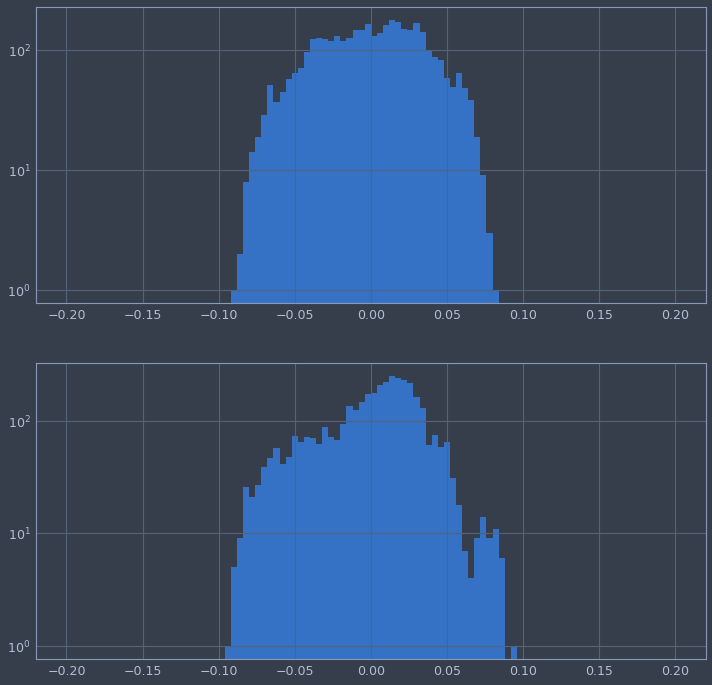

In [63]:
fig = plt.figure(1, (12, 12))
ax1 = fig.add_subplot(211)

dd_Lat_cv['del'].hist(bins = 100, ax = ax1, range = (-0.2,0.2), log = True)
ax2 = fig.add_subplot(212)

dd_Long_cv['del'].hist(bins = 100, ax = ax2, range = (-0.2,0.2), log= True) 

http://server.arcgisonline.com/ArcGIS/rest/services/World_Topo_Map/MapServer/export?bbox=-71.2,42.2,-70.95,42.46&bboxSR=4269&imageSR=4269&size=1000,1039&dpi=96&format=png32&transparent=true&f=image


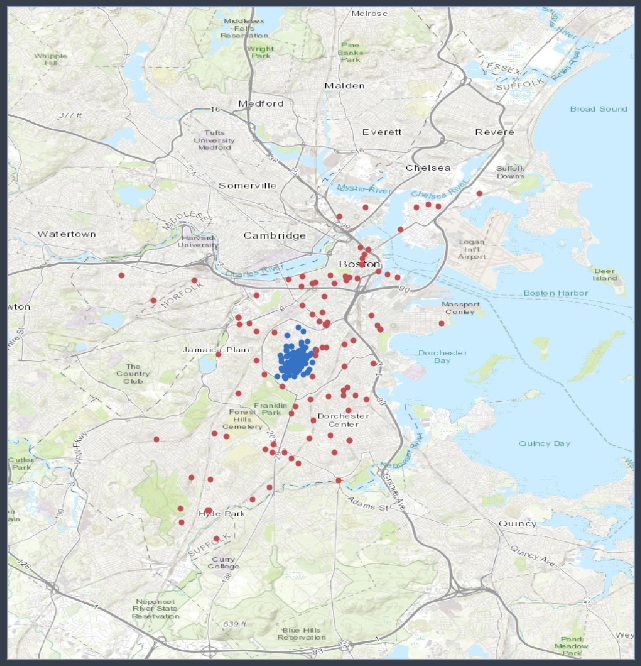

In [64]:
plt.figure(figsize=(12,12))
map = Basemap(llcrnrlon=-71.2, llcrnrlat=42.2, urcrnrlon=-70.95, urcrnrlat=42.46, epsg=4269)
    #http://server.arcgisonline.com/arcgis/rest/services
    #EPSG Number of America is 4269
#World_Street_Map
#World_Topo_Map
map.arcgisimage(service='World_Topo_Map', xpixels = 1000, verbose= True)

random.seed(3)
for rr in range(100):
    rnd_int = random.randint(0,len(dd_Lat_cv))
    coordinat_true_Lat = y1[rnd_int]    
    coordinat_true_Long = y2[rnd_int]
    coordinat_pred_Lat = pred_Lat_cv[rnd_int]    
    coordinat_pred_Long = pred_Long_cv[rnd_int]  
 
    xpt1,ypt1 = map(coordinat_true_Long,coordinat_true_Lat)
    map.scatter(xpt1,ypt1,c = 'r')

    xpt2,ypt2 = map(coordinat_pred_Long,coordinat_pred_Lat)
    map.scatter(xpt2,ypt2,c = 'b')
    


In [65]:
pd.DataFrame({'colum': X_train.columns, 'coef':np.abs(model1_cv.coef_)}).sort_values(['coef'], ascending=False).head(10)

colum      coef
88      Avg Temp (F)  0.020877
29            HOUR_2  0.010469
87     High Temp (F)  0.010282
89      Low Temp (F)  0.008963
94  Avg Humidity (%)  0.008423
34            HOUR_7  0.007521
35            HOUR_8  0.006095
30            HOUR_3  0.004988
2       SHOOTING_NON  0.004930
3         SHOOTING_Y  0.004930

In [66]:
pd.DataFrame({'colum': X_train.columns, 'coef':np.abs(model2_cv.coef_)}).sort_values(['coef'], ascending=False).head(10)

colum      coef
90  High Dew Point (F)  0.006306
58               DAY_7  0.004069
29              HOUR_2  0.003991
33              HOUR_6  0.003663
16             MONTH_9  0.003278
83         Events_Both  0.003224
88        Avg Temp (F)  0.002965
91   Avg Dew Point (F)  0.002942
34              HOUR_7  0.002773
61              DAY_10  0.002758

## RandomForestRegressor

In [67]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [68]:
%%time
#params = {'n_estimators':[160],'max_depth':[20]}
rfc1=RandomForestRegressor(random_state=42, n_jobs= 3, n_estimators = 200)
#rfc1_grid = GridSearchCV(rfc1,param_grid=params,cv=3,n_jobs= 3)
rfc1.fit(X_train, y1_train)
#rfc1=rfc1_grid.best_estimator_ # assign best model to rfc

CPU times: user 35.5 s, sys: 60.7 ms, total: 35.5 s
Wall time: 12 s


In [69]:
rfc1

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=3,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

Text(0.5, 1.0, 'Feature Importance')

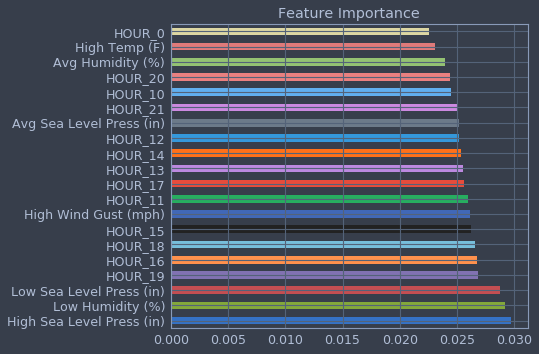

In [70]:
(pd.Series(rfc1.feature_importances_, index=X_train.columns)
   .nlargest(20)
   .plot(kind='barh'))
plt.title('Feature Importance') # top 10 features

In [71]:
%%time
rfc2=RandomForestRegressor(random_state=42, n_jobs= 3, n_estimators = 200)
#rfc2_grid = GridSearchCV(rfc2,param_grid=params,cv=5, n_jobs= 3)
rfc2.fit(X_train, y2_train)
#rfc2=rfc2_grid.best_estimator_ # assign best model to rfc

CPU times: user 34 s, sys: 65.5 ms, total: 34.1 s
Wall time: 11.5 s


In [72]:
rfc2

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=3,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

Text(0.5, 1.0, 'Feature Importance')

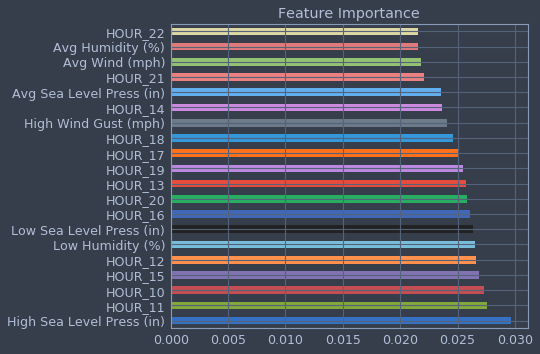

In [73]:
(pd.Series(rfc2.feature_importances_, index=X_train.columns)
   .nlargest(20)
   .plot(kind='barh'))
plt.title('Feature Importance') # top 10 features

In [74]:
pred_Lat_rfr = rfc1.predict(X_val)
mse_Lat_rfr = mean_absolute_error(y1_val, pred_Lat_rfr)
pred_Long_rfr = rfc2.predict(X_val)
mse_Long_rfr = mean_absolute_error(y2_val, pred_Long_rfr)

In [75]:
mse_Lat_rfr, mse_Long_rfr

(0.030429744569867349, 0.028137834755500489)

In [76]:
mse_Lat_cv, mse_Long_cv

(0.028199360855785581, 0.026046247104928717)

http://server.arcgisonline.com/ArcGIS/rest/services/World_Topo_Map/MapServer/export?bbox=-71.2,42.2,-70.95,42.46&bboxSR=4269&imageSR=4269&size=1000,1039&dpi=96&format=png32&transparent=true&f=image


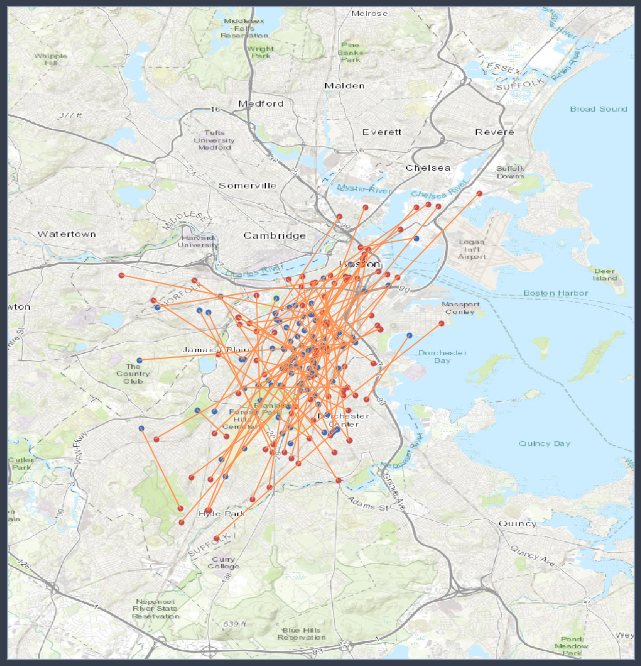

In [77]:
plt.figure(figsize=(12,12))
map = Basemap(llcrnrlon=-71.2, llcrnrlat=42.2, urcrnrlon=-70.95, urcrnrlat=42.46, epsg=4269)
    #http://server.arcgisonline.com/arcgis/rest/services
    #EPSG Number of America is 4269
#World_Street_Map
#World_Topo_Map
map.arcgisimage(service='World_Topo_Map', xpixels = 1000, verbose= True)

random.seed(3)
for rr in range(100):
    rnd_int = random.randint(0,len(dd_Lat_cv))
    coordinat_true_Lat = y1[rnd_int]    
    coordinat_true_Long = y2[rnd_int]
    coordinat_pred_Lat = pred_Lat_rfr[rnd_int]    
    coordinat_pred_Long = pred_Long_rfr[rnd_int]  
    
    xpt1,ypt1 = map(coordinat_true_Long,coordinat_true_Lat)
    map.scatter(xpt1,ypt1,c = 'r')

    xpt2,ypt2 = map(coordinat_pred_Long,coordinat_pred_Lat)
    map.scatter(xpt2,ypt2,c = 'b')
    
    map.plot((xpt1,xpt2),(ypt1,ypt2),c = 'y')

## LassoCV

In [78]:
model3 = LassoCV(random_state = 42)
model4 = LassoCV(random_state = 42)

model3.fit(X_train, y1_train)
model4.fit(X_train, y2_train)

/home/aaa/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/aaa/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/aaa/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/aaa/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: 

LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
    positive=False, precompute='auto', random_state=42, selection='cyclic',
    tol=0.0001, verbose=False)

In [79]:
pred_Lat_3 = model3.predict(X_val)
mse_Lat_3 = mean_absolute_error(y1_val, pred_Lat_3)

pred_Long_3 = model4.predict(X_val)
mse_Long_3 = mean_absolute_error(y2_val, pred_Long_3)

In [80]:
mse_Lat_3, mse_Long_3

(0.028138649855446254, 0.025971318520103096)

<Figure size 864x864 with 0 Axes>

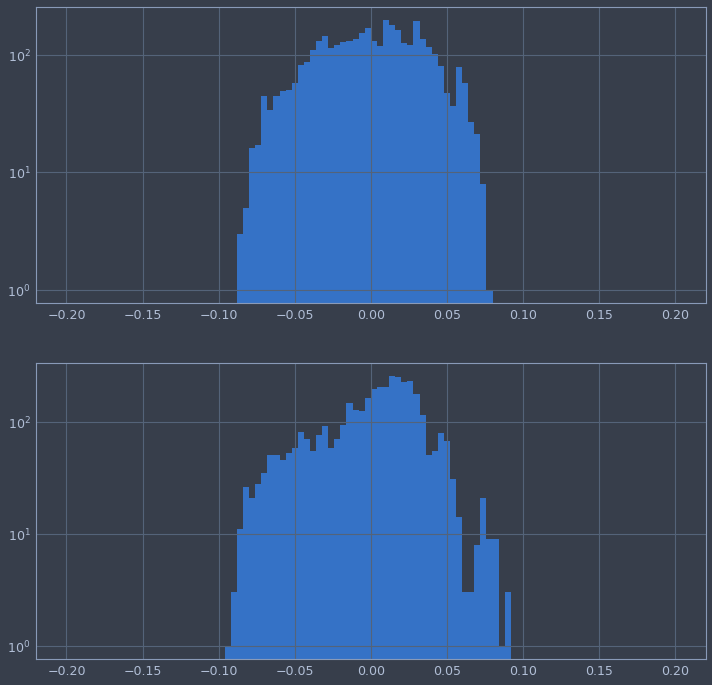

<Figure size 864x864 with 0 Axes>

In [81]:
dd_Lat_lasso = pd.DataFrame({'tr':y1_val, 'pred': pred_Lat_3, 'del': (y1_val - pred_Lat_3)}).sort_values(by=['del'])
dd_Long_lasso = pd.DataFrame({'tr':y2_val, 'pred': pred_Long_3, 'del': (y2_val - pred_Long_3)}).sort_values(by=['del'])

fig = plt.figure(1, (12, 12))
ax1 = fig.add_subplot(211)

dd_Lat_lasso['del'].hist(bins = 100, ax = ax1, range = (-0.2,0.2), log = True)
ax2 = fig.add_subplot(212)

dd_Long_lasso['del'].hist(bins = 100, ax = ax2, range = (-0.2,0.2), log= True) 

plt.figure(figsize=(12,12))

http://server.arcgisonline.com/ArcGIS/rest/services/World_Topo_Map/MapServer/export?bbox=-71.2,42.2,-70.95,42.46&bboxSR=4269&imageSR=4269&size=1000,1039&dpi=96&format=png32&transparent=true&f=image


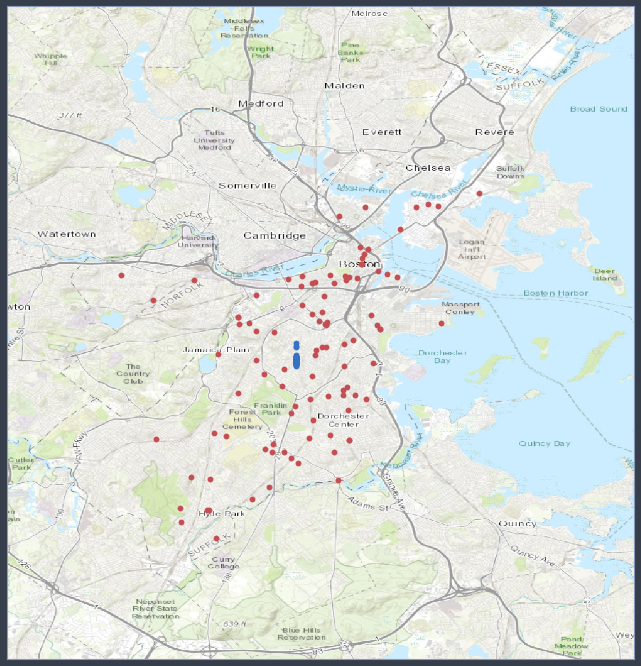

In [82]:
plt.figure(figsize=(12,12))
map = Basemap(llcrnrlon=-71.2, llcrnrlat=42.2, urcrnrlon=-70.95, urcrnrlat=42.46, epsg=4269)
map.arcgisimage(service='World_Topo_Map', xpixels = 1000, verbose= True)

random.seed(3)

for rr in range(100):

    rnd_int = random.randint(0,len(dd_Lat_cv))
    coordinat_true_Lat = y1[rnd_int]    
    coordinat_true_Long = y2[rnd_int]
    coordinat_pred_Lat = pred_Lat_3[rnd_int]    
    coordinat_pred_Long = pred_Long_3[rnd_int]  

 
    xpt1,ypt1 = map(coordinat_true_Long,coordinat_true_Lat)
    map.scatter(xpt1,ypt1,c = 'r')

    xpt2,ypt2 = map(coordinat_pred_Long,coordinat_pred_Lat)
    map.scatter(xpt2,ypt2,c = 'b')



In [83]:
model3.intercept_

42.319852291287347

In [84]:
pd.DataFrame({'colum': X_train.columns, 'coef':np.abs(model3.coef_)}).sort_values(['coef'], ascending=False).head(10)

colum      coef
29       HOUR_2  0.005654
35       HOUR_8  0.002446
16      MONTH_9  0.001414
34       HOUR_7  0.001090
85  Events_Rain  0.000828
52        DAY_1  0.000724
58        DAY_7  0.000672
28       HOUR_1  0.000665
19     MONTH_12  0.000626
18     MONTH_11  0.000517

In [85]:
pd.DataFrame({'colum': X_train.columns, 'coef':np.abs(model4.coef_)}).sort_values(['coef'], ascending=False).head(10)

colum  coef
0   OFFENSE_CODE_3006   0.0
80             DAY_29   0.0
78             DAY_27   0.0
77             DAY_26   0.0
76             DAY_25   0.0
75             DAY_24   0.0
74             DAY_23   0.0
73             DAY_22   0.0
72             DAY_21   0.0
71             DAY_20   0.0

## catboost

In [86]:
df_total.head()

INCIDENT_NUMBER  OFFENSE_CODE    OFFENSE_CODE_GROUP    OFFENSE_DESCRIPTION  \
0      I182080026          2629            Harassment             HARASSMENT   
1      I182069920          3201         Property Lost        PROPERTY - LOST   
2      I172103391          1107                 Fraud  FRAUD - IMPERSONATION   
3      I172091689          3115    Investigate Person     INVESTIGATE PERSON   
4      I172089119          3114  Investigate Property   INVESTIGATE PROPERTY   

  DISTRICT REPORTING_AREA SHOOTING    OCCURRED_ON_DATE  YEAR  MONTH   ...    \
0       C6            256      NON 2017-08-31 00:00:00  2017      8   ...     
1       B2            287      NON 2017-08-31 12:08:00  2017      8   ...     
2      C11            396      NON 2017-08-31 00:00:00  2017      8   ...     
3      E18            492      NON 2017-08-31 09:00:00  2017      8   ...     
4       B3            446      NON 2017-08-31 09:00:00  2017      8   ...     

  Low Sea Level Press (in)  High Visibility (mi) Avg Visibility (mi)  \
0                    29.81                    10                  10   
1                    29.81                    10                  10   
2                    29.81                    10                  10   
3                    29.81                    10                  10   
4                    29.81                    10                  10   

  Low Visibility (mi)  High Wind (mph)  Avg Wind (mph) High Wind Gust (mph)  \
0                  10               22              12                   28   
1                  10               22              12                   28   
2                  10               22              12                   28   
3                  10               22              12                   28   
4                  10               22              12                   28   

   Snowfall (in)  Precip (in)  Events  
0            0.0          0.0    None  
1            0.0          0.0    None  
2            0.0          0.0    None  
3            0.0          0.0    None  
4            0.0          0.0    None  

[5 rows x 43 columns]

In [87]:
for c in df_total.columns:
    col_type = df_total[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        df_total[c] = df_total[c].astype('category')

In [88]:
X_total = df_total.copy()
X_total.drop(['STREET','DISTRICT','REPORTING_AREA','OFFENSE_DESCRIPTION','Lat', 'Long','Location','INCIDENT_NUMBER','OCCURRED_ON_DATE','test_one','Year', 'Month', 'Day'], axis = 1, inplace=True) 

In [89]:
X_total = X_total[X_total['OFFENSE_CODE']==3006]

In [90]:
X_train, X_val, y1_train, y1_val, y2_train, y2_val = train_test_split(X_total, y1, y2, random_state = 42)

In [91]:
for i, c in enumerate(X_total.columns):
    col_type = df_total[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        print(i)

1
2
5
7
29


In [92]:
SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted'])

In [93]:
param = {'iterations':3000, 'depth':10, 'learning_rate':0.03, 'loss_function':'RMSE', 'random_seed' : 42, 
                           'task_type' : "GPU", 'cat_features' : [1,2,5,7,29],'verbose':0}

In [94]:
model_y1 = CatBoostRegressor(**param)
#catboost_pool = Pool(X_train, y1_train, cat_features = [1,2,5,7,29])
model_y1.fit(X_train, y1_train)


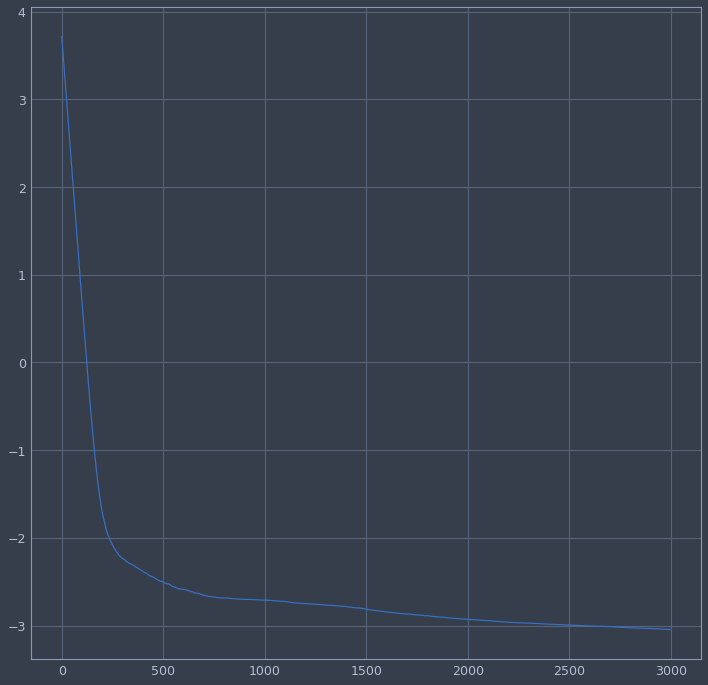

In [95]:
fig = plt.figure(1, (12, 12))
plt.plot(np.log(model_y1.evals_result_['learn']['RMSE']))

In [96]:
%%time
#rsCV_y1 = RandomizedSearchCV(model_y1, param_distributions={'iterations':[100,500,1000,2000], 'depth':[i for i in range(2,15)]}, n_iter=20, n_jobs=1, random_state=42, scoring='neg_median_absolute_error')
#rsCV_y1.fit(X_train, y1_train)

CPU times: user 8 µs, sys: 1e+03 ns, total: 9 µs
Wall time: 5.96 µs


In [97]:
model_y2 = CatBoostRegressor(**param )
model_y2.fit(X_train, y2_train)


In [98]:
%%time
#rsCV_y2 = RandomizedSearchCV(model_y2, param_distributions={'iterations':[100,500,1000,2000], 'depth':[i for i in range(2,15)]}, n_iter=20, n_jobs=1, random_state=42, scoring='neg_median_absolute_error')
#rsCV_y2.fit(X_train, y2_train)

CPU times: user 7 µs, sys: 2 µs, total: 9 µs
Wall time: 5.25 µs


In [99]:
#rsCV_y1.best_params_, rsCV_y1.best_params_

In [100]:
#y1_pred = rsCV_y1.best_estimator_.predict(X_val)
#y2_pred = rsCV_y2.best_estimator_.predict(X_val)
y1_pred = model_y1.predict(X_val)
y2_pred = model_y2.predict(X_val)

In [101]:
y1_pred, y2_pred

(array([ 42.31953773,  42.31776226,  42.3367063 , ...,  42.31275426,
         42.32444174,  42.32062506]),
 array([-71.10006231, -71.08579674, -71.0962243 , ..., -71.08376563,
        -71.09213796, -71.08895456]))

In [102]:
mse_Lat_boost = mean_absolute_error(y1_val, y1_pred)
mse_Long_boost = mean_absolute_error(y2_val, y2_pred)

In [103]:
mse_Lat_boost, mse_Long_boost

(0.029561721897140208, 0.030543626256335884)

http://server.arcgisonline.com/ArcGIS/rest/services/World_Topo_Map/MapServer/export?bbox=-71.2,42.2,-70.95,42.46&bboxSR=4269&imageSR=4269&size=1000,1039&dpi=96&format=png32&transparent=true&f=image


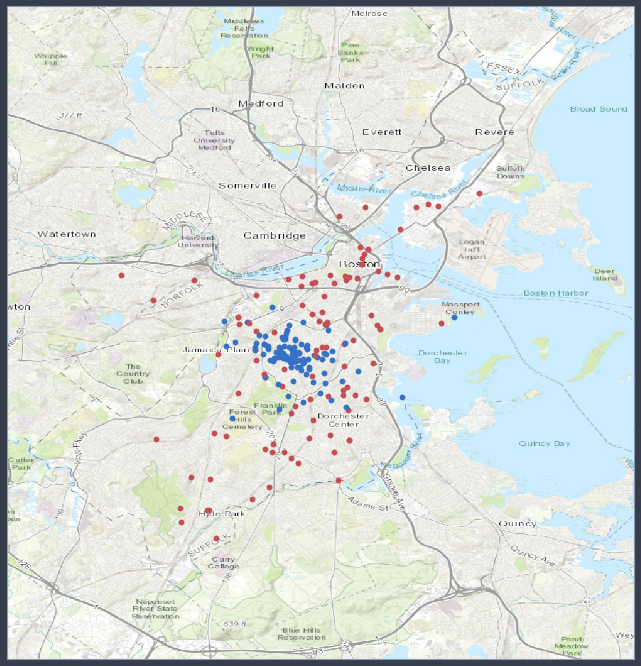

In [104]:
plt.figure(figsize=(12,12))
map = Basemap(llcrnrlon=-71.2, llcrnrlat=42.2, urcrnrlon=-70.95, urcrnrlat=42.46, epsg=4269)
    #http://server.arcgisonline.com/arcgis/rest/services
    #EPSG Number of America is 4269
#World_Street_Map
#World_Topo_Map
map.arcgisimage(service='World_Topo_Map', xpixels = 1000, verbose= True)

random.seed(3)
for rr in range(100):
    rnd_int = random.randint(0,len(y1_pred))
    coordinat_true_Lat = y1[rnd_int]    
    coordinat_true_Long = y2[rnd_int]
    coordinat_pred_Lat = y1_pred[rnd_int]    
    coordinat_pred_Long = y2_pred[rnd_int]  
    
    xpt1,ypt1 = map(coordinat_true_Long,coordinat_true_Lat)
    map.scatter(xpt1,ypt1,c = 'r')

    xpt2,ypt2 = map(coordinat_pred_Long,coordinat_pred_Lat)
    map.scatter(xpt2,ypt2,c = 'b')

 #   map.plot((xpt1,xpt2),(ypt1,ypt2),c = 'y')
    

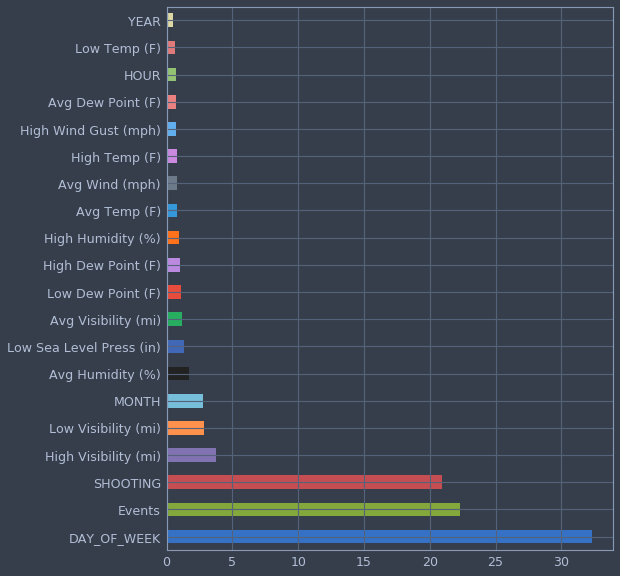

In [105]:
feat_imp = pd.Series(model_y2.feature_importances_, index=X_train.columns)
feat_imp.nlargest(20).plot(kind='barh', figsize=(8,10))

## 9. Создание новых признаков и описание этого процесса (4 балла)
(+) Созданы новые признаки. Дано обоснование: логическое (например, у птиц температура тела на несколько градусов выше человеческой, значит вирус ХХХ не выживет в такой среде), физическое (например, радуга означает, что источник света расположен сзади; расчет величины по физическому закону с использованием данных признаков) или другое (скажем, признак построен после визуализации данных). Обоснование разумно описано. Полезность новых признаков подтверждена статистически или с помощью соответствующей модели;

In [106]:
X.columns


Index(['OFFENSE_CODE', 'OFFENSE_CODE_GROUP', 'SHOOTING', 'OCCURRED_ON_DATE',
       'YEAR', 'MONTH', 'DAY_OF_WEEK', 'HOUR', 'UCR_PART', 'Lat', 'Long',
       'DAY', 'High Temp (F)', 'Avg Temp (F)', 'Low Temp (F)',
       'High Dew Point (F)', 'Avg Dew Point (F)', 'Low Dew Point (F)',
       'High Humidity (%)', 'Avg Humidity (%)', 'Low Humidity (%)',
       'High Sea Level Press (in)', 'Avg Sea Level Press (in)',
       'Low Sea Level Press (in)', 'High Visibility (mi)',
       'Avg Visibility (mi)', 'Low Visibility (mi)', 'High Wind (mph)',
       'Avg Wind (mph)', 'High Wind Gust (mph)', 'Snowfall (in)',
       'Precip (in)', 'Events'],
      dtype='object')

In [107]:
df = X


In [108]:
aggr_df = df.groupby('OCCURRED_ON_DATE')[['Lat']].count()
aggr_df.columns = ['Lat_count']
aggr_df.head()

Lat_count
OCCURRED_ON_DATE              
2015-06-15 01:07:00          1
2015-06-15 01:53:00          1
2015-06-15 06:53:00          1
2015-06-15 08:00:00          1
2015-06-15 09:23:00          1

In [109]:
daily_df = aggr_df.resample('D').apply(sum)
daily_df.head(n=10)

Lat_count
OCCURRED_ON_DATE           
2015-06-15               13
2015-06-16                5
2015-06-17               12
2015-06-18                9
2015-06-19               10
2015-06-20                8
2015-06-21               10
2015-06-22               11
2015-06-23               10
2015-06-24               11

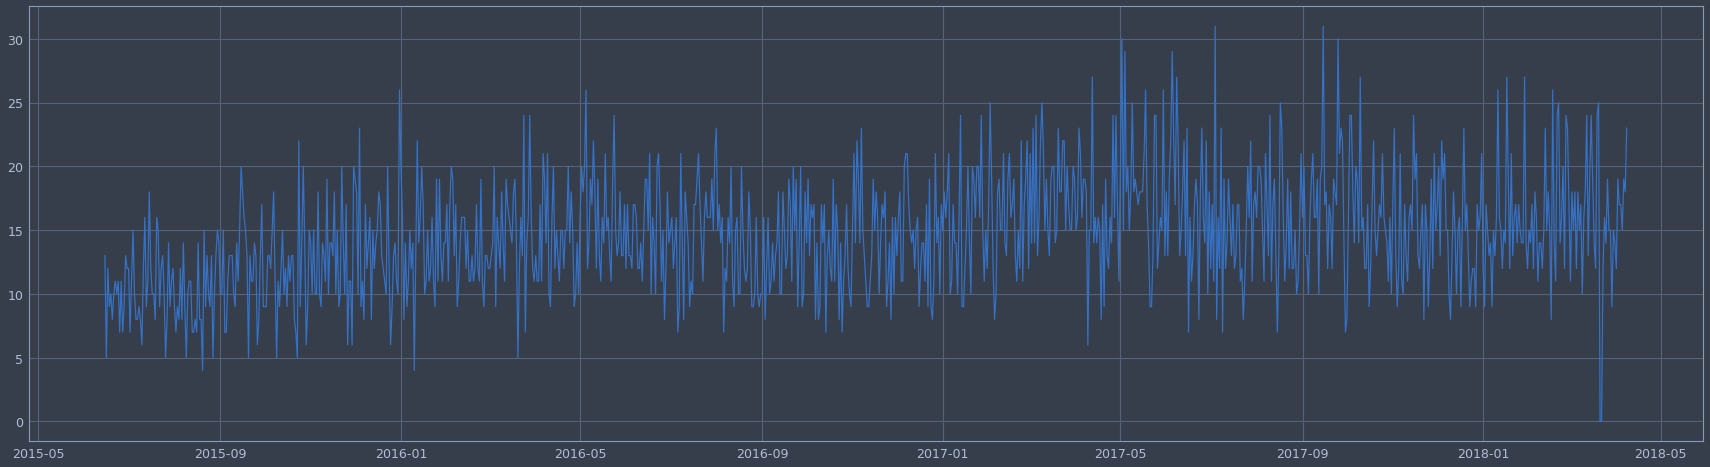

In [110]:
fig = plt.figure(figsize=(30,8))
plt.plot(daily_df.index, daily_df.Lat_count)

In [111]:
weekly_df = daily_df.resample('W').apply(sum)   

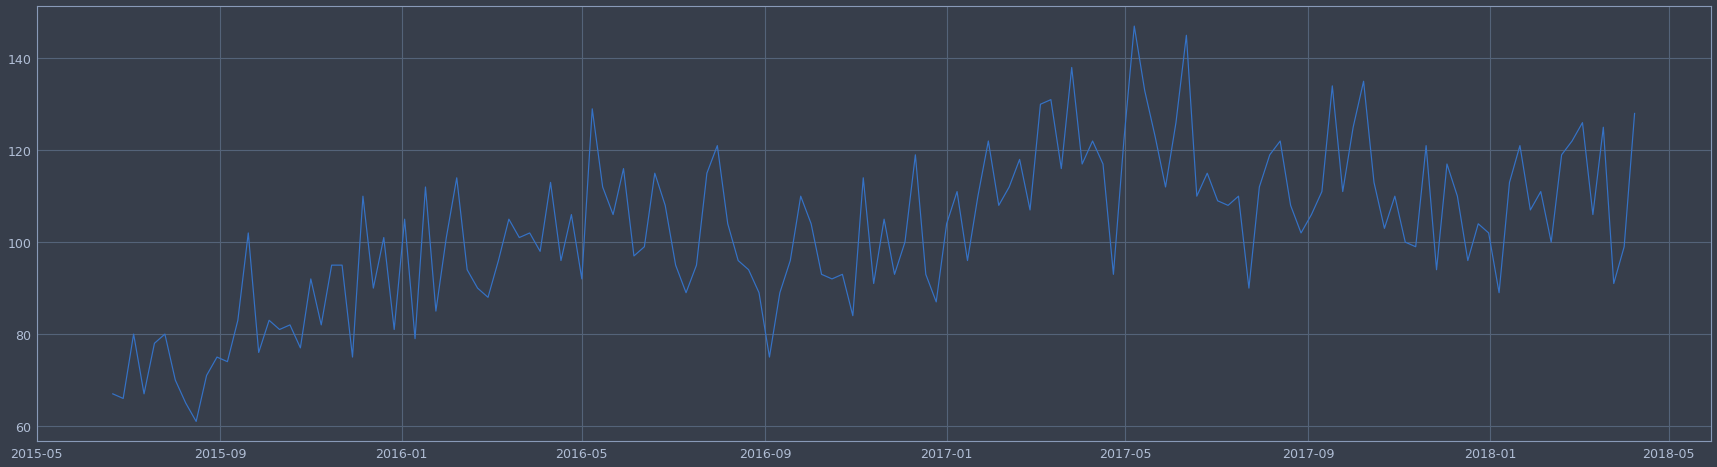

In [112]:
fig = plt.figure(figsize=(30,8))
plt.plot(weekly_df.index, weekly_df.Lat_count)

In [113]:
from fbprophet import Prophet

import logging
logging.getLogger().setLevel(logging.ERROR)

In [114]:
df = daily_df
df.columns = ['y']
df.index.name = 'ds'

In [117]:
prediction_size = 90
train_df = df[:-prediction_size]
train_df.tail(n=3)
train_df['ds'] = train_df.index

In [118]:
m = Prophet()
m.fit(train_df);

In [119]:
future = m.make_future_dataframe(periods=prediction_size)
future.tail(n=3)

ds
1026 2018-04-06
1027 2018-04-07
1028 2018-04-08

In [120]:
forecast = m.predict(future)
forecast.tail(n=3)

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
1026 2018-04-06  17.224464   12.604864   22.543356    17.206773    17.241071   
1027 2018-04-07  17.227862   11.344875   21.116886    17.209978    17.244730   
1028 2018-04-08  17.231261   11.015284   20.569836    17.213085    17.248678   

      additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
1026        0.544954              0.544954              0.544954  0.119222   
1027       -0.768113             -0.768113             -0.768113 -1.047034   
1028       -1.471149             -1.471149             -1.471149 -1.617698   

      weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
1026      0.119222      0.119222  0.425732      0.425732      0.425732   
1027     -1.047034     -1.047034  0.278921      0.278921      0.278921   
1028     -1.617698     -1.617698  0.146548      0.146548      0.146548   

      multiplicative_terms  multiplicative_terms_lower  \
1026                   0.0                         0.0   
1027                   0.0                         0.0   
1028                   0.0                         0.0   

      multiplicative_terms_upper       yhat  
1026                         0.0  17.769417  
1027                         0.0  16.459749  
1028                         0.0  15.760111

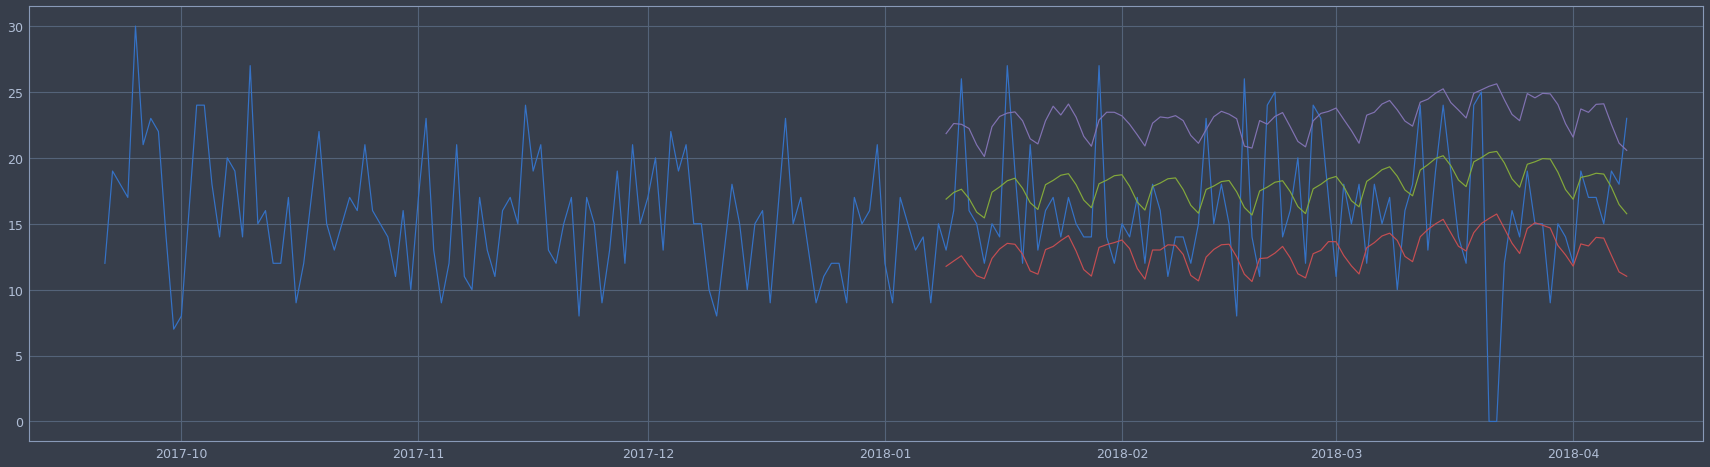

In [123]:
fig = plt.figure(figsize=(30,8))
plt.plot(df.y.tail(200));
plt.plot(forecast.ds.tail(prediction_size), forecast.yhat.tail(prediction_size));
plt.plot(forecast.ds.tail(prediction_size), forecast.yhat_lower.tail(prediction_size));
plt.plot(forecast.ds.tail(prediction_size), forecast.yhat_upper.tail(prediction_size));

In [132]:
def make_comparison_dataframe(historical, forecast):
    """Join the history with the forecast.
    
       The resulting dataset will contain columns 'yhat', 'yhat_lower', 'yhat_upper' and 'y'.
    """
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical)

In [136]:
cmp_df = make_comparison_dataframe(df, forecast)
cmp_df.tail(n=10)

yhat  yhat_lower  yhat_upper   y
ds                                               
2018-03-30  18.917334   13.351448   24.048780  15
2018-03-31  17.593851   12.637369   22.595199  14
2018-04-01  16.858565   11.785619   21.569850  12
2018-04-02  18.520069   13.471849   23.711370  19
2018-04-03  18.640024   13.315750   23.454589  17
2018-04-04  18.832911   13.965569   24.061306  17
2018-04-05  18.770055   13.909948   24.101146  15
2018-04-06  17.769417   12.604864   22.543356  19
2018-04-07  16.459749   11.344875   21.116886  18
2018-04-08  15.760111   11.015284   20.569836  23

In [134]:
def calculate_forecast_errors(df, prediction_size):
    df = df.copy()
    df['e'] = df['y'] - df['yhat']
    predicted_part = df[-prediction_size:]
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    return {'MAE': error_mean('e')}

In [135]:
for err_name, err_value in calculate_forecast_errors(cmp_df, prediction_size).items():
    print(err_name, err_value)

MAE 4.17322637138


In [137]:
data = pd.DataFrame(df.y.copy())
data.columns = ["y"]

In [138]:
# Adding the lag of the target variable from 6 steps back up to 24
for i in range(6, 45):
    data["lag_{}".format(i)] = data.y.shift(i)

In [139]:
data.tail(7)

y  lag_6  lag_7  lag_8  lag_9  lag_10  lag_11  lag_12  lag_13  \
ds                                                                           
2018-04-02  19   15.0   19.0   14.0   16.0    12.0     0.0     0.0    25.0   
2018-04-03  17   15.0   15.0   19.0   14.0    16.0    12.0     0.0     0.0   
2018-04-04  17    9.0   15.0   15.0   19.0    14.0    16.0    12.0     0.0   
2018-04-05  15   15.0    9.0   15.0   15.0    19.0    14.0    16.0    12.0   
2018-04-06  19   14.0   15.0    9.0   15.0    15.0    19.0    14.0    16.0   
2018-04-07  18   12.0   14.0   15.0    9.0    15.0    15.0    19.0    14.0   
2018-04-08  23   19.0   12.0   14.0   15.0     9.0    15.0    15.0    19.0   

            lag_14   ...    lag_35  lag_36  lag_37  lag_38  lag_39  lag_40  \
ds                   ...                                                     
2018-04-02    24.0   ...      24.0    12.0    20.0    16.0    14.0    25.0   
2018-04-03    25.0   ...      23.0    24.0    12.0    20.0    16.0    14.0   
2018-04-04     0.0   ...      17.0    23.0    24.0    12.0    20.0    16.0   
2018-04-05     0.0   ...      11.0    17.0    23.0    24.0    12.0    20.0   
2018-04-06    12.0   ...      18.0    11.0    17.0    23.0    24.0    12.0   
2018-04-07    16.0   ...      15.0    18.0    11.0    17.0    23.0    24.0   
2018-04-08    14.0   ...      18.0    15.0    18.0    11.0    17.0    23.0   

            lag_41  lag_42  lag_43  lag_44  
ds                                          
2018-04-02    24.0    11.0    14.0    26.0  
2018-04-03    25.0    24.0    11.0    14.0  
2018-04-04    14.0    25.0    24.0    11.0  
2018-04-05    16.0    14.0    25.0    24.0  
2018-04-06    20.0    16.0    14.0    25.0  
2018-04-07    12.0    20.0    16.0    14.0  
2018-04-08    24.0    12.0    20.0    16.0  

[7 rows x 40 columns]

In [140]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

In [141]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [142]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [143]:
y_ = data.dropna().y
X_ = data.dropna().drop(['y'], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X_, y_, test_size=0.3)

In [144]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [145]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

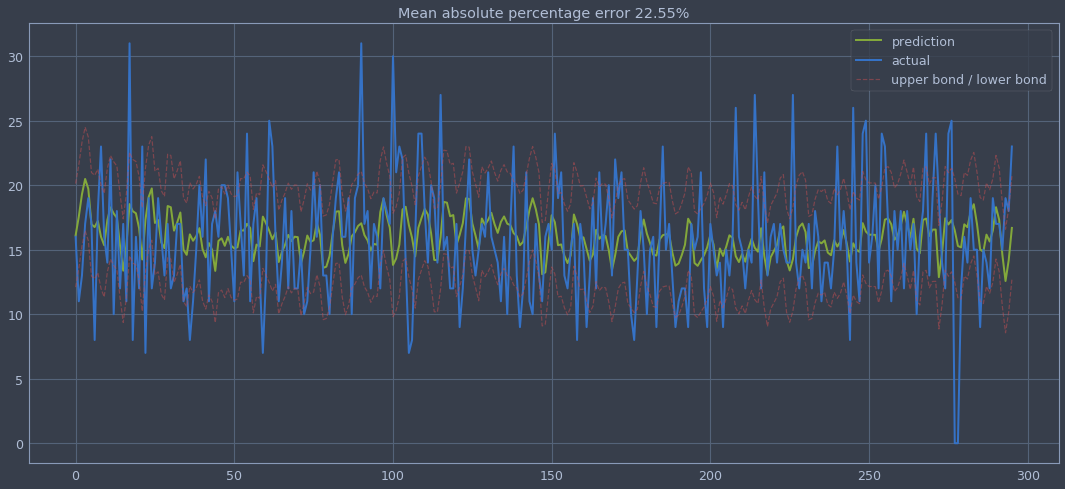

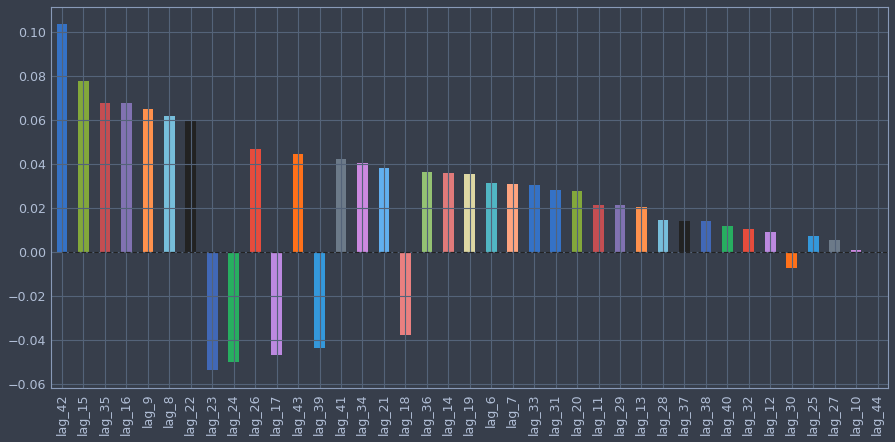

In [146]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

In [147]:
data.index = pd.to_datetime(data.index)
data["day"] = data.index.day
data["weekday"] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5,6])*1
data.tail()

y  lag_6  lag_7  lag_8  lag_9  lag_10  lag_11  lag_12  lag_13  \
ds                                                                           
2018-04-04  17    9.0   15.0   15.0   19.0    14.0    16.0    12.0     0.0   
2018-04-05  15   15.0    9.0   15.0   15.0    19.0    14.0    16.0    12.0   
2018-04-06  19   14.0   15.0    9.0   15.0    15.0    19.0    14.0    16.0   
2018-04-07  18   12.0   14.0   15.0    9.0    15.0    15.0    19.0    14.0   
2018-04-08  23   19.0   12.0   14.0   15.0     9.0    15.0    15.0    19.0   

            lag_14     ...      lag_38  lag_39  lag_40  lag_41  lag_42  \
ds                     ...                                               
2018-04-04     0.0     ...        12.0    20.0    16.0    14.0    25.0   
2018-04-05     0.0     ...        24.0    12.0    20.0    16.0    14.0   
2018-04-06    12.0     ...        23.0    24.0    12.0    20.0    16.0   
2018-04-07    16.0     ...        17.0    23.0    24.0    12.0    20.0   
2018-04-08    14.0     ...        11.0    17.0    23.0    24.0    12.0   

            lag_43  lag_44  day  weekday  is_weekend  
ds                                                    
2018-04-04    24.0    11.0    4        2           0  
2018-04-05    25.0    24.0    5        3           0  
2018-04-06    14.0    25.0    6        4           0  
2018-04-07    16.0    14.0    7        5           1  
2018-04-08    20.0    16.0    8        6           1  

[5 rows x 43 columns]

In [148]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

/home/aaa/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/aaa/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/aaa/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  import sys


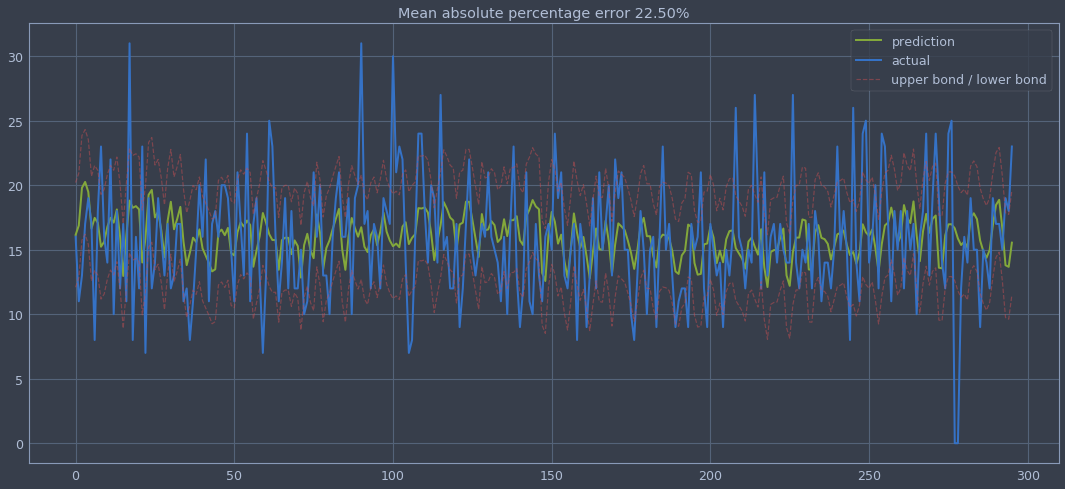

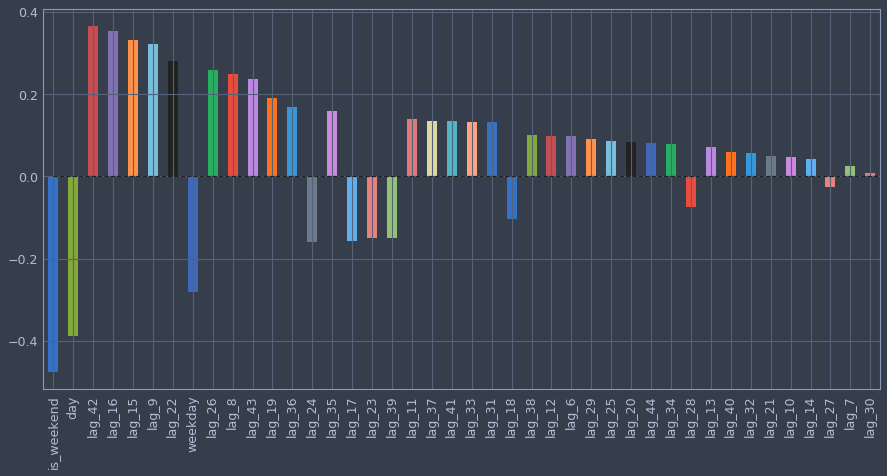

In [149]:
y_ = data.dropna().y
X_ = data.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X_, y_, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
plotCoefficients(lr)

In [150]:
def code_mean(data, cat_feature, real_feature):
    """
    Returns a dictionary where keys are unique categories of the cat_feature,
    and values are means over real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

def prepareData(series, lag_start, lag_end, test_size, target_encoding=False):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset

        target_encoding: boolean
            if True - add target averages to the dataset
        
    """
    
    # copy of the initial dataset
    data = pd.DataFrame(series.copy())
#    data.columns = ["y"]
    
    # lags of series
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
    
    # datetime features
#    data.index = pd.to_datetime(data.index)
    data["day"] = data.index.day
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    
    if target_encoding:
        # calculate averages on train set only
        test_index = int(len(data.dropna())*(1-test_size))
        data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
        data["day_average"] = list(map(code_mean(data[:test_index], 'day', "y").get, data.day))

        # drop encoded variables 
        data.drop(["day", "weekday"], axis=1, inplace=True)
    
    # train-test split
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test

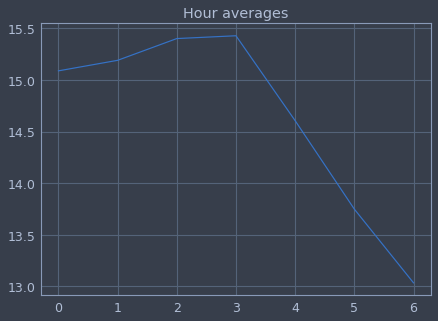

In [151]:
average_hour = code_mean(data, 'weekday', "y")
plt.figure(figsize=(7, 5))
plt.title("Hour averages")
pd.DataFrame.from_dict(average_hour, orient='index')[0].plot()
plt.grid(True);

/home/aaa/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/aaa/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/aaa/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


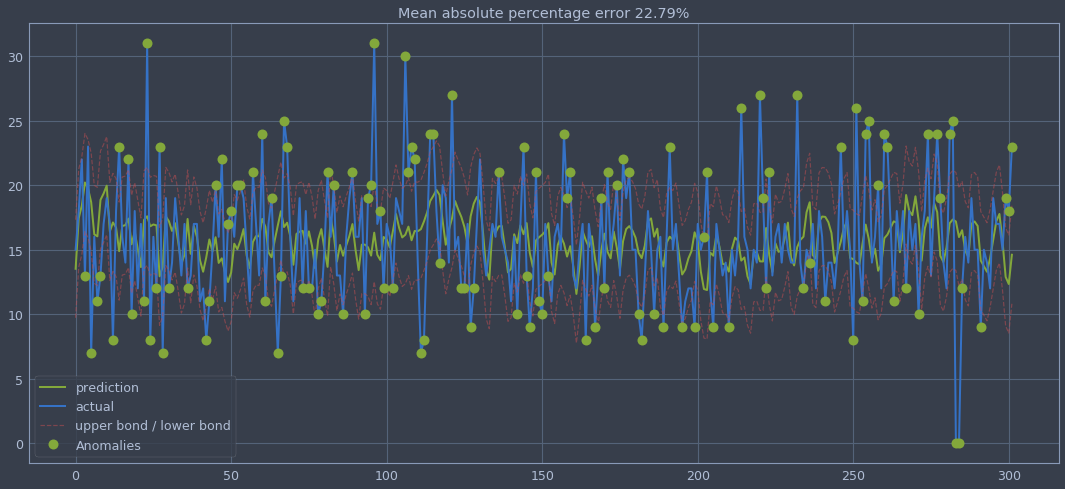

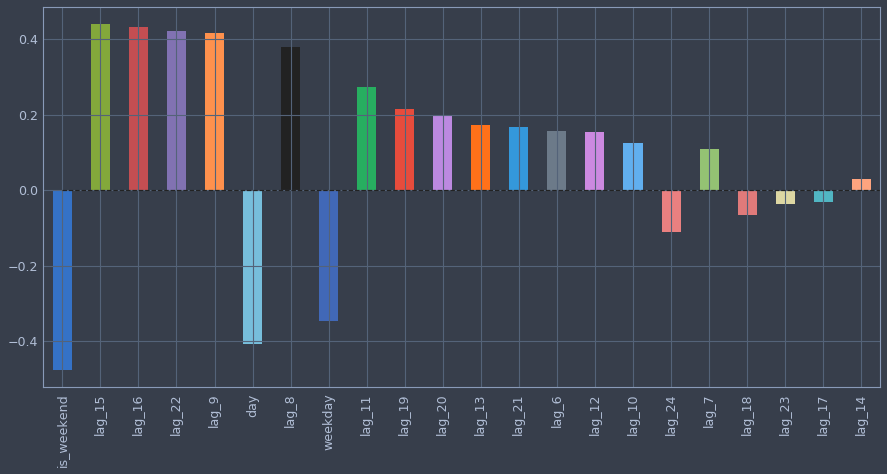

In [157]:
X_train, X_test, y_train, y_test = prepareData(daily_df, lag_start=6, lag_end=25, test_size=0.3, target_encoding=False)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)

## 11. Прогноз для тестовой или отложенной выборке (2 балла)
(+) Указаны результаты на тестовой выборке или LB score. Результаты на тестовой выборке сравнимы с результатами на кросс-валидации. Если тестовая выборка создавалась автором проекта, то механизм создания должен быть непредвзят и объяснен (применен разумный механизм выборки, в простейшем случае – рандомизация);